In [1]:
from google.colab import files
files.upload()  # Select your kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hashirattari","key":"f9e82d8643af05967e345cef56b760c5"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d omkargurav/face-mask-dataset
!unzip face-mask-dataset.zip -d big_mask_dataset


Streaming output truncated to the last 5000 lines.
  inflating: big_mask_dataset/data/with_mask/with_mask_3297.jpg  
  inflating: big_mask_dataset/data/with_mask/with_mask_3298.jpg  
  inflating: big_mask_dataset/data/with_mask/with_mask_3299.jpg  
  inflating: big_mask_dataset/data/with_mask/with_mask_33.jpg  
  inflating: big_mask_dataset/data/with_mask/with_mask_330.jpg  
  inflating: big_mask_dataset/data/with_mask/with_mask_3300.jpg  
  inflating: big_mask_dataset/data/with_mask/with_mask_3301.jpg  
  inflating: big_mask_dataset/data/with_mask/with_mask_3302.jpg  
  inflating: big_mask_dataset/data/with_mask/with_mask_3303.jpg  
  inflating: big_mask_dataset/data/with_mask/with_mask_3304.jpg  
  inflating: big_mask_dataset/data/with_mask/with_mask_3305.jpg  
  inflating: big_mask_dataset/data/with_mask/with_mask_3306.jpg  
  inflating: big_mask_dataset/data/with_mask/with_mask_3307.jpg  
  inflating: big_mask_dataset/data/with_mask/with_mask_3308.jpg  
  inflating: big_mask_datase

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [15]:
IMG_SIZE = 224
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_data = datagen.flow_from_directory(
    "big_mask_dataset/data",
    target_size=(224,224),
    batch_size=32,
    class_mode="binary",
    subset="training"
)

val_data = datagen.flow_from_directory(
    "big_mask_dataset/data",
    target_size=(224,224),
    batch_size=32,
    class_mode="binary",
    subset="validation"
)



Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.


In [16]:
base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [17]:
callbacks = [

        EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),

    ModelCheckpoint(
        "best_face_mask_model.h5",
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]


In [18]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9404 - loss: 0.1398
Epoch 1: val_accuracy improved from -inf to 0.98609, saving model to best_face_mask_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 36s 145ms/step - accuracy: 0.9405 - loss: 0.1394 - val_accuracy: 0.9861 - val_loss: 0.0339 - learning_rate: 0.0010
Epoch 2/20
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9901 - loss: 0.0271
Epoch 2: val_accuracy did not improve from 0.98609
189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.9901 - loss: 0.0271 - val_accuracy: 0.9861 - val_loss: 0.0404 - learning_rate: 0.0010
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9939 - loss: 0.0180
Epoch 3: val_accuracy did not improve from 0.98609
189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.9938 - loss: 0.0180 - val_accuracy: 0.9848 - val_loss: 0.0443 - learning_rate: 0.0010
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9971 - loss: 0.0089
Epoch 4: val_accuracy improved from 0.98609 to 0.98808, saving model to best_face_mask_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.9971 - loss: 0.0089 - val_accuracy: 0.9881 - val_loss: 0.0320 - learning_rate: 0.0010
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9992 - loss: 0.0044
Epoch 5: val_accuracy improved from 0.98808 to 0.98940, saving model to best_face_mask_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.9992 - loss: 0.0044 - val_accuracy: 0.9894 - val_loss: 0.0334 - learning_rate: 0.0010
Epoch 6/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9979 - loss: 0.0064
Epoch 6: val_accuracy did not improve from 0.98940
189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.9979 - loss: 0.0064 - val_accuracy: 0.9887 - val_loss: 0.0322 - learning_rate: 0.0010
Epoch 7/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9996 - loss: 0.0023
Epoch 7: val_accuracy improved from 0.98940 to 0.99139, saving model to best_face_mask_model.h5



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
189/189 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.9996 - loss: 0.0023 - val_accuracy: 0.9914 - val_loss: 0.0390 - learning_rate: 0.0010
Epoch 8/20
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9994 - loss: 0.0023
Epoch 8: val_accuracy improved from 0.99139 to 0.99205, saving model to best_face_mask_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.9994 - loss: 0.0023 - val_accuracy: 0.9921 - val_loss: 0.0285 - learning_rate: 3.0000e-04
Epoch 9/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 9: val_accuracy did not improve from 0.99205
189/189 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9901 - val_loss: 0.0315 - learning_rate: 3.0000e-04
Epoch 10/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9997 - loss: 0.0012
Epoch 10: val_accuracy did not improve from 0.99205
189/189 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 0.9907 - val_loss: 0.0319 - learning_rate: 3.0000e-04
Epoch 11/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 6.2277e-04
Epoch 11: val_accuracy did not improve from 0.99205

Epoch 11: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 1.00

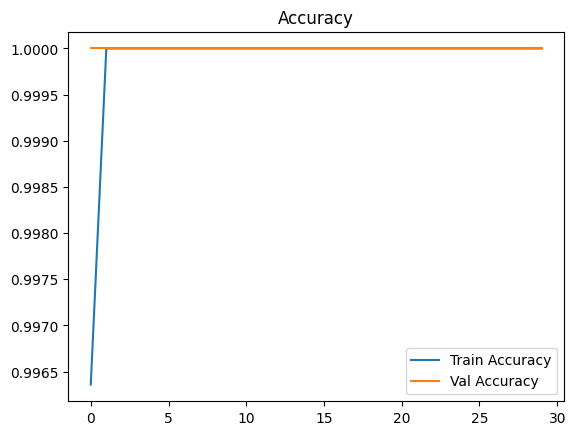

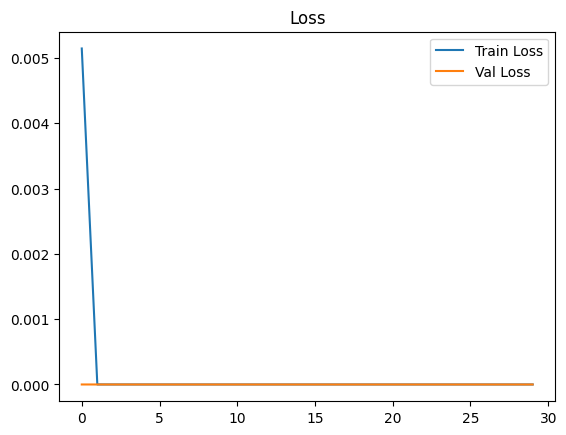

In [12]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()


In [13]:
!ls big_mask_dataset


data


In [21]:
# Agar model abhi train ho chuka hai aur history available hai
val_acc = history.history['val_accuracy'][-1]  # last epoch validation accuracy
print(f"Validation Accuracy: {val_acc*100:.2f}%")


Validation Accuracy: 99.07%
